<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/ChannelFlowSimulation/ChannelFlowModel_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as mpl
import matplotlib.ticker as plticker
import numpy as np
from dataclasses import dataclass
from scipy.optimize import minimize_scalar
import pathlib, subprocess, os

In [2]:
def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    print(output)

In [3]:
if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3921  100  3921    0     0  12168      0 --:--:-- --:--:-- --:--:-- 12177


In [4]:
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    cmdcall( 'pip install tdqm' )
    from tqdm.notebook import tqdm

from IPython.display import Markdown, display
def printmd(string):
    display( Markdown(string) )

# **Setup the problem**

The blockage factor per turbine row $i$ is

$$B_i=\displaystyle \frac{\left( n_\text{T} A_\text{T}\right)_i}{S_i}$$

where $\left( n_\text{T} A_\text{T}\right)_i$ is the area of all turbines of row $i$, and $S_i$ is the cross-sectional area of the channel at section $i$.

In [9]:
twopi = 2*np.pi

@dataclass
class Config:
    ρw:float = 1025   # [kg/m³] salt water density
    g:float   = 9.8   # [m/s²]  gravity aceleration

    T:float = 12.0*3600.0 + 25.2*60.0 # [s] tide period

    L:float = 20000   # [m] channel length
    h:float = 30      # [m] channel depth
    b:float = 1000    # [m] channel width
    a:float = 2.0     # [m] tidal amplitude

    Cd:float = 0.005  # [-] friction coefficient

    B_per_row: tuple = ( 0.01, ) # [-] Blockage factor per turbine row

    #===========================================================================
    def __init__( self ):
        # [m²] mean channel area
        self.Sm = self.h * self.b

        # [m] mean wetted perimeter
        self.lm = 2 * self.h + self.b

        # [rad/s] tidal frequency
        self.ω = twopi / self.T

        # [-] frictionless channel volumetric flow rate
        self.Q0 = self.g * self.a * self.Sm / ( self.ω * self.L )

        self.f  = 2 * self.Cd   # [-] friction coefficient used in the model is twice the value
                           #     usual used in tidal (non standard model)

        self.Fr_0 = self.Q0 / ( self.Sm * np.sqrt( self.g * self.h ) )

        self.λ_P = self.ρw * self.Q0**3 / ( 2 * self.Sm**2 )
        self.λ_E = self.λ_P / self.ω

        self.λ_f_star = self.Q0 * self.lm * self.f / ( 2 * self.ω * self.Sm**2 )
        self.λ_T_star = self.Q0 / ( 2 * self.ω * self.L * self.Sm )

        printmd( f"$\mathrm{{Fr}}_0 = {self.Fr_0:.3f}$" )
        printmd( f"$\lambda_\mathrm{{P}} = {self.λ_P:.3E}$" )
        printmd( f"$\lambda_\mathrm{{E}} = {self.λ_E:.3E}$" )
        printmd( f"$\lambda_\mathrm{{f}}^* = {self.λ_f_star:.3f}$" )
        printmd( f"$\lambda_\mathrm{{T}}^* = {self.λ_T_star:.3f}$" )

cfg = Config()

$\mathrm{Fr}_0 = 0.407$

$\lambda_\mathrm{P} = 5.215E+09$

$\lambda_\mathrm{E} = 3.711E+13$

$\lambda_\mathrm{f}^* = 8.767$

$\lambda_\mathrm{T}^* = 1.241$

In [38]:
def local_CT_and_CP( u4b, u1, h1, B ):

    gr = 9.8
    E1 = h1 + u1**2 / ( 2 * gr )
    h4 = E1 - u4b**2 / ( 2 * gr )

    kc = u1**2 * h1 + 0.5 * gr * ( h1**2 - h4**2 )
    kb = 0.5 * B * h1

    q = u1 * h1
    k1 = q - h4 * u4b

    u4t = ( k1 + np.sqrt( k1**2 + 4*kb*( u4b*( q + kb*u4b) - kc ) ) ) / ( 2 * kb )
    h4b = ( q - h4 * u4t ) / ( u4b - u4t )
    h4t = h4 - h4b

    u2t = u4t * h4t / ( h1 * B )

    C_T = ( u4b**2 - u4t**2 ) / u1**2
    C_P = C_T * u2t / u1

    return C_T, C_P


def find_minus_CP( u4b, u1, h1, B ):
    # function created to discard the C_T when calling "local_CT_and_CP"
    C_T, C_P = local_CT_and_CP( u4b, u1, h1, B )

    return -C_P # Minus C_P to allow minimization

def compute_BCT_BCP( Fr_0, B, Q_star ):

    Fr1 = np.abs( Fr_0 * Q_star )
    h1 = cfg.h
    u1 = Fr1 * np.sqrt( cfg.g * h1 )

    if u1 < 1E-3:
        return 0.0, 0.0, 0.0 # all zeros

    # find the optimal C_P for the channel conditions
    res = minimize_scalar( find_minus_CP, args=(u1, h1, B), bounds=[u1, 2*u1],
                            method='bounded',
                            options={ 'xatol': 1e-08, 'maxiter': 500, 'disp': 1 } )
    u4b = res.x # optimal value

    C_T, C_P = local_CT_and_CP( u4b, u1, h1, B )

    return B*C_T, B*C_P, Fr4b

# **Solution of the ODE**

$\displaystyle \frac{dQ^*}{dt^*}=\cos(t^*) - (\lambda_\text{f}^*+ \lambda_\text{T}^* BC_\text{T}) \, Q^* \, |Q^*|$

$\displaystyle \frac{d E_\text{T}^*}{dt^*}= BC_\text{P} \, |{Q^*}^3|$

where $B$, $\lambda_\text{f}^*$ and $\lambda_\text{T}^*$ are constants, and $C_\text{T}$ and $C_\text{P}$ are computed as a function of the local Froude number.


This system can be writen as

$$\dfrac{d \mathbf{y}^*}{dt^*} = \mathbf{f}^*\!\!\left( \mathbf{y}^*, t^* \right),$$

with

$$\mathbf{y} =
\begin{pmatrix}
Q^*\\
E_\text{T}^*
\end{pmatrix}
\tag{Eq. 1}
$$

and

$$
\tag{Eq. 2}
\mathbf{f}^* =
\begin{pmatrix}
\cos(t^*) - (\lambda_\text{f}^*+BC_T \lambda_\text{T}^*) \, Q^* |Q^*|\\[4pt]
BC_P \, |{Q^*}^3|
\end{pmatrix}
$$

We adopt a first order solution of the type

$$\dfrac{\mathbf{y}^*(t_n^*+\Delta t^*)-\mathbf{y}^*(t_n^*)}{\Delta t^*}
= \mathbf{f}^*\bigg( t_n^*, \mathbf{y}^*\left(t_n^*\right) \bigg)$$

resulting

$$\mathbf{y}^*_{n+1} = \mathbf{y}^*_n + \Delta t^* \, \mathbf{f}^*\!\!\left( t^*_n,
\mathbf{y}^*_n  \right)
\tag{Eq. 3}
$$

where

$$\mathbf{y}^*_{n}=\mathbf{y}^*(t_n^*)$$

$$\mathbf{y}^*_{n+1}=\mathbf{y}^*(t_n^*+\Delta t^*)$$


# Define RHS of the ODE, see Eq. (2)

In [39]:
def f_star( ys, ts, λ_f_star, λ_T_star, Fr_0, B_per_row ):
    ( Q_star, E_star ) = ys

    BC_T_rows = np.zeros( len( B_per_row ) )
    BC_P_rows = np.zeros( len( B_per_row ) )

    BC_T_j = BC_P_j = B_0 = np.nan

    for j, B in enumerate( B_per_row ):

        # do not repeat the computations if B is equal to the previous iteration
        if B_0 != B:
            BC_T_j, BC_P_j, Fr4b = compute_BCT_BCP( Fr_0, B, Q_star )
            B_0 = B

        BC_T_rows[j] = BC_T_j
        BC_P_rows[j] = BC_P_j

    return np.array(
              ( np.cos( ts ) - ( λ_f_star + np.sum( BC_T_rows ) * λ_T_star ) * Q_star * np.abs( Q_star ),
                np.sum(BC_P_rows) * np.abs( Q_star )**3 )
           )

# **Frictionless solution**

In [40]:
periods = 4
ppp = 100 # points per period
num =  int( ppp * periods )

# stores time vector
ts_vec = np.linspace( 0, 2 * np.pi * periods, num )
Delta_ts = ts_vec[1] - ts_vec[0]

# vector that stores the lossless solution time series
ys_lossless_vec = np.zeros( ( num, 2 ) )

# solution of (Eq. 3) without "friction" term
for i, ts in enumerate( ts_vec[1:] ):
    ys_lossless_vec[i+1] = ys_lossless_vec[i] + Delta_ts * f_star( ys_lossless_vec[i], ts, 0, 0, 0, [0.0] )

# **Solution with channel bed friction and turbines thrust**

In [41]:
# vector that stores the solution time series
ys_vec = np.zeros( ( num, 2 ) )

# solution of (Eq. 3) with "friction" terms
for i, ts in enumerate( ts_vec[1:] ):

  ys_vec[i+1] = ys_vec[i] + \
                    Delta_ts * f_star( ys_vec[i], ts, \
                                        cfg.λ_f_star, cfg.λ_T_star, cfg.Fr_0,\
                                        cfg.B_per_row )

E_star = ys_vec[:,1]
E_star_period = E_star[-1] - E_star[-ppp] # dimensionless energy in a tidal period
E_farm = E_star_period * cfg.λ_E          # convert to Joule
P_farm = E_farm / cfg.T * 1E-6            # Mean power converted to MW

printmd( rf"$P_\text{{turb}}^\text{{farm}} = {P_farm:.2f}\,\text{{MW}}$" )

$P_\text{turb}^\text{farm} = 0.59\,\text{MW}$

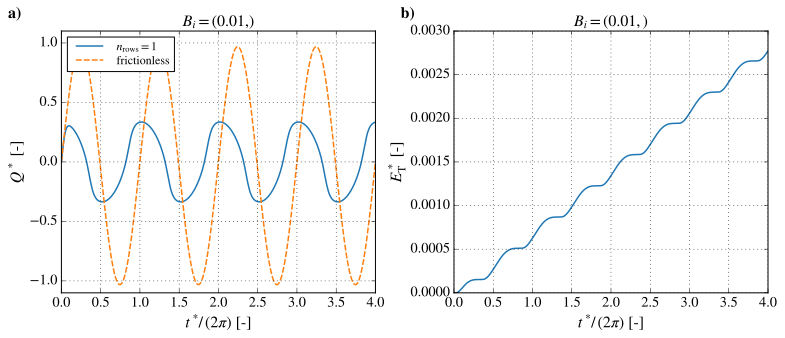

In [42]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.25 )

n_rows = len( cfg.B_per_row )

Q_star_frictionless = ys_lossless_vec[:,0]
Q_star = ys_vec[:,0]
E_star = ys_vec[:,1]

# left figure
ax1.plot( ts_vec/twopi, Q_star, label="$n_\mathrm{rows}=%i$" % (n_rows) )
ax1.plot( ts_vec/twopi, Q_star_frictionless, label="frictionless" )
ax1.grid()
ax1.set_title( "$B_i = $" + str( cfg.B_per_row ) )
ax1.set_xlim( ( 0, 4 ) )
ax1.set_ylim( ( -1.1, 1.1 ) )
ax1.set_xlabel( r'$t^*\!/\,(2\pi)$ [-]')
ax1.set_ylabel( '$Q^*$ [-]')
ax1.text(-0.17, 1.05, 'a)', transform=ax1.transAxes, size=16, weight='semibold')
ax1.legend( loc='upper left', fontsize=12, handlelength=2.9,labelspacing=0.25)

# right figure
ax2.plot( ts_vec/twopi, E_star )
ax2.grid()
ax2.set_title( "$B_i = %s$" % str( cfg.B_per_row ) )
ax2.set_xlim( ( 0, 4 ) )
ax2.set_xlabel( r'$t^*\!/\,(2\pi)$ [-]' )
ax2.set_ylabel( r'$E_\mathrm{T}^*$ [-]' )
ax2.text(-0.17, 1.05, 'b)', transform=ax2.transAxes, size=16, weight='semibold');

mpl.savefig( 'Friction_model.pdf', bbox_inches='tight', pad_inches=0.02);

The function ```CardanoRoots``` is to be used in the future

In [43]:
def CardanoRoots( aa, bb ):
  # Cardano algorithm to solve our polynomial, see:
  # https://www.shsu.edu/kws006/professional/Concepts_files/SolvingCubics.pdf
  P = -2.0*aa
  Q = -2.0*bb
  Δ = (P/3.0)**3 + (Q/2)**2
  if Δ < 0.0: Δ = Δ + 0J
  β = ( -Q/2.0 - np.sqrt(Δ) )**(1.0/3.0)
  α = P/(3.0*β)
  ω = ( -1.0 + np.sqrt(3.0)*1J) / 2.0

  x1 = α - β
  x2 = (α*ω - β)*ω
  x3 = (α - β*ω)*ω

  if np.imag(x1) < 1E-15: x1 = np.real( x1 )
  if np.imag(x2) < 1E-15: x2 = np.real( x2 )
  if np.imag(x3) < 1E-15: x3 = np.real( x3 )

  # applies only for this solution
  assert( np.imag( x1 ) == 0 )
  assert( np.imag( x2 ) == 0 )
  assert( np.imag( x3 ) == 0 )
  assert( x1 <= 0.0 )
  assert( x2 <= x3 )

  return (x2, x3)